# Exploring dataset spermatogonia dataset

The following notebook is for exploring GuavaMuse FCS files relating to spermatogonial enrichment procedure for Western Diet Experiment.
Briefly, 3 mouses were fed Western Diet, 3 mouses were fed control diet (one mouse from control group died).
Their testicles were isolated, underwent enyzmic digestion, then enriched via MojoSort c-kit kit. C-kit antibody should preferentially bind to spermatogonial cells.

Every mouse was considered one "biounit" - prefix WD meaning mice fed Western Diet, and prefix C menaing mice fed control diet

Two datasets were obtained, with (unfortunately) different flow cytometry settings:
- one acquired on 26th April 2021 consisting of 3 biounits (WD_1, WD_2, C_1)
- one acquired on 30th April 2021 consisting of 2 biounits (WD_3, C_2)

Four fractions per one mouse were gotten:
- INP - unmarked testicular suspension
- PM  - testicular suspension marked with c-kit antibody
- M   - testicular suspension magnetically depleted for cells marked with c-kit
- S   - testicular suspension magnetically enriched for cells marked with c-kit

Additionally, suspension consisting solely of debris of testicular cells (determined visually via hemocytometer) was recorded using two different cytometry settings. This debris full data will be denoted as Debris and can be used to estimate Y value cutoff beneath which all events are considered debris, and above which all events are considered cells.

The following code sections will be present :
1. Drawing scatterplots of data overlayed with its respective debris
2. Removing debris from data according to the above drawings
3. Drawing debris-free data
4. Estimating number of spermatogonial cells, as well as enrichment and depletion of MojoSort c-kit magnetic sorting

In [3]:
#preliminary data gathering - importing from .FCS files and naming gathered samples
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt


sys.path.insert(1,r"C:\Users\ivanp\OneDrive\Desktop\Python projeklti\fcparsiranje")
from GuavaMuseDrawer import text_explanation, parse
from GuavaMuseDrawer.gui_enrichment import create_bunit_frac
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

_og_path=r"C:\Users\ivanp\OneDrive\Desktop\Python projeklti\Jupyter Notebooks\Spermatogonia enrichment_WD1\muse_recordings"
_debr26_path=_og_path+r"\26APR-debr.FCS"
_debr30_path=_og_path+r"\30APR-debr.FCS"
_data26_path=_og_path+r"\26APR.FCS"
_data30_path=_og_path+r"\30APR.FCS"
#Setting data as global
global debr26, debr30, data26, data30
global total26, total30 #<-data + upscaled debris

#DATASET LOADING
#preliminary dataset cleaning
#- creating Biounit and Fraction columns
#- renaming name???
data26=text_explanation(_data26_path)
data30=text_explanation(_data30_path)
data26.Name="Data"
data30.Name="Data"
create_bunit_frac(data26)
create_bunit_frac(data30)

#DEBRIS LOADING
#preliminary debris cleaning
#-"upscaling" debris dataset for nicer seaborn manipulation (see converting_debris func)
#-creating Biounit and Fraction columns
debr26=parse(_debr26_path)
debr30=parse(_debr30_path)

def converting_debris(data,debris):
    """
    Upscales debris to data:
        for every unique Sample entry in data, one debris is copied, 
        and its Sample is set to that of a data
        and at the end debris are concated
    Example:
        Sample in dataset has 8 samples
        This creates 8 identical debris dataframes, with difference only in Sample
        This then creates debris dataframe 8 times larger than the original debris
    This dataset is removed
    
    """
    _l=[]
    for item in set(data.Sample):
        _debri_df=debris.copy()
        _debri_df.Sample=item
        _l.append(_debri_df)
    final_debris=pd.concat(_l,ignore_index=True)
    return(final_debris)

debr26=converting_debris(data26,debr26)
debr30=converting_debris(data30,debr30)
create_bunit_frac(debr26)
create_bunit_frac(debr30)

debr26.Name="Debris"
debr30.Name="Debris"

total26=pd.concat([data26,debr26],ignore_index=True) #330000 = 150000 + 180000
total30=pd.concat([data30,debr30],ignore_index=True) #245496 = 125496 + 120000

#fraction and biounit defining
fractions=sorted(list(set(data26.Fraction)))

ModuleNotFoundError: No module named 'GuavaMuseDrawer.gui_enrichment'

# Scatterplot drawer
The following segment enables user to select and draw scatterplot of dataset (26th or 30th April) how it was acquired on Muse - X is Yellow Flourescence Logarithmic Height (PE), Y is Forward Scatter Logarithmic Height (measuring cell size). Every dataset is overlayed with its respective debris. Additionally, Y slider is here to enable user to pinpoint threshold they want to use as a debris cutoff value. 

Additionally, next two segments will draw scatterplots and histograms of data without debris. 

In [2]:
#data drawing - draw scatterplot of a dataset with debris included as hue
def scatterplot_drawer(dataset,fraction,line):

    if dataset == 26:
        data = total26
    else:
        data = total30
    drawn_data=data.loc[data.Fraction==fraction]
    graph=sns.relplot(data=drawn_data,kind="scatter",x="YEL-HLog",y="FSC-HLog",s=1,hue="Name",col="Biounit")
    for ax in graph._axes_dict.values():
        ax.axhline(line,color="red")
    
    

#defining widgets
datasetW = widgets.Dropdown(options = [26,30],
                         value=26,
                         description = "What Dataset to Draw")
fractionW = widgets.Dropdown(options=fractions,
                            value=fractions[0],
                            description="What Fraction to Draw")
h_lineW = widgets.FloatSlider(value=3.5,
                                min=0.0,
                                max=4.0,
                                step=0.1,
                                description = "Y axis")
# interactive segment
widgets.interactive(scatterplot_drawer,dataset=datasetW,fraction=fractionW,line=h_lineW)

NameError: name 'fractions' is not defined

In [3]:
#default values estimated by creator of this Notebook
# for dataset 26 - FSC-HLog = 3.5
# for dataset 30 - FSC-HLog = 2.7
#to change, simply change the following variables
cutoff_26 = 3.5
cutoff_30 = 2.7

data26=data26.loc[data26["FSC-HLog"]>=cutoff_26]
data30=data30.loc[data30["FSC-HLog"]>=cutoff_30]

global all_data
all_data = pd.concat([data26,data30],ignore_index=True)
_d={"WD_1":"WD","WD_2":"WD","WD_3":"WD","C_1":"C","C_2":"C"}
all_data["Treatment"]=all_data["Biounit"].map(_d)

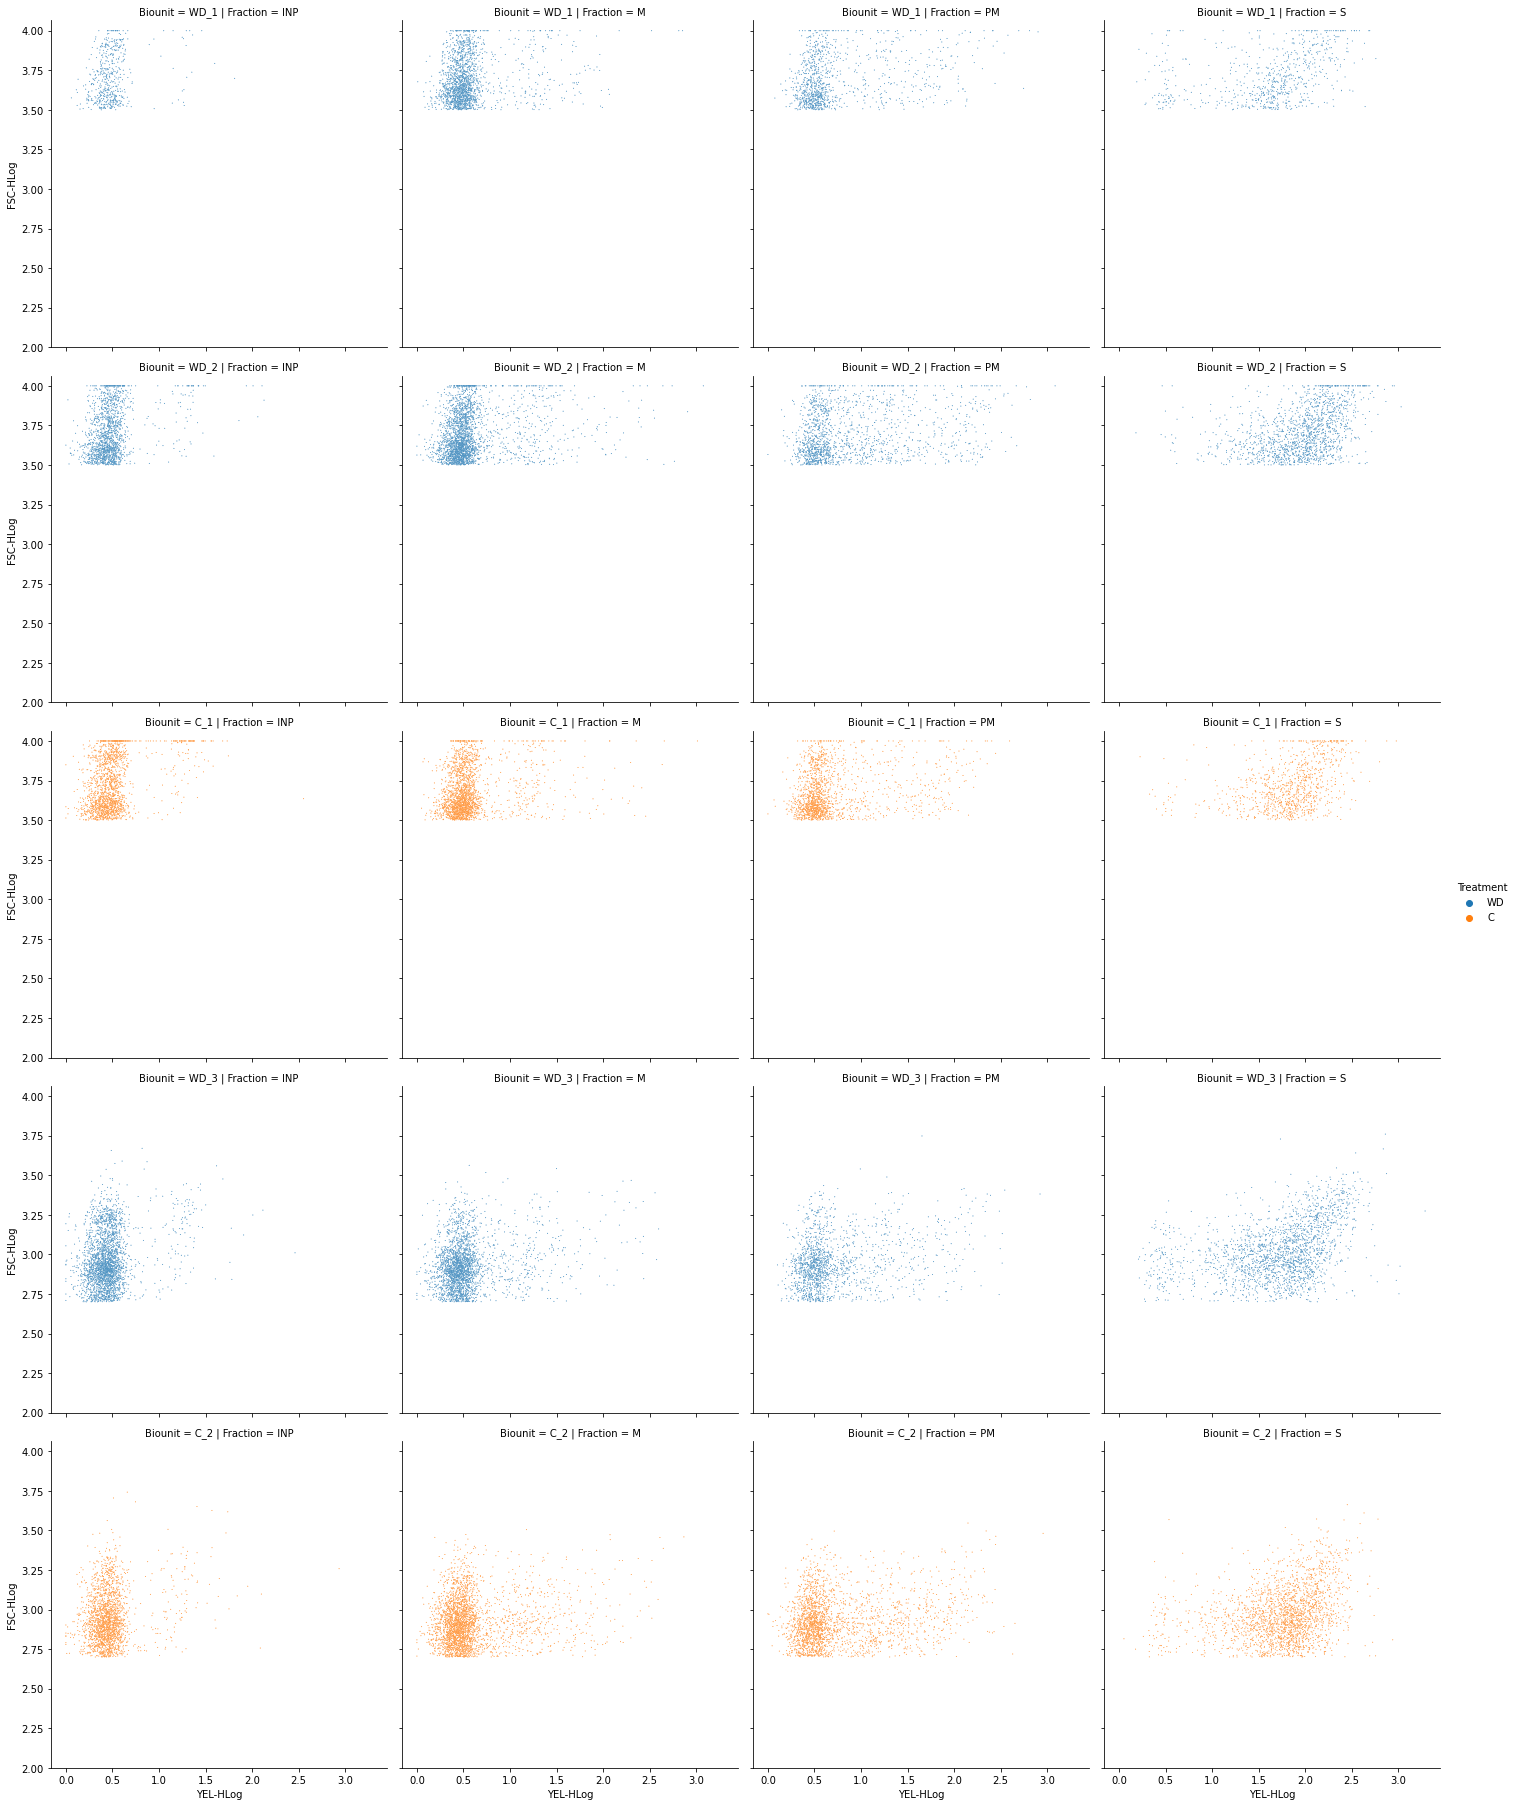

In [4]:
scatter=sns.relplot(data=all_data,x="YEL-HLog",y="FSC-HLog",s=1,col="Fraction",row="Biounit",col_order=["INP","M","PM","S"], row_order=["WD_1","WD_2","C_1","WD_3","C_2"],hue="Treatment")
scatter.set(ylim=(2,None))

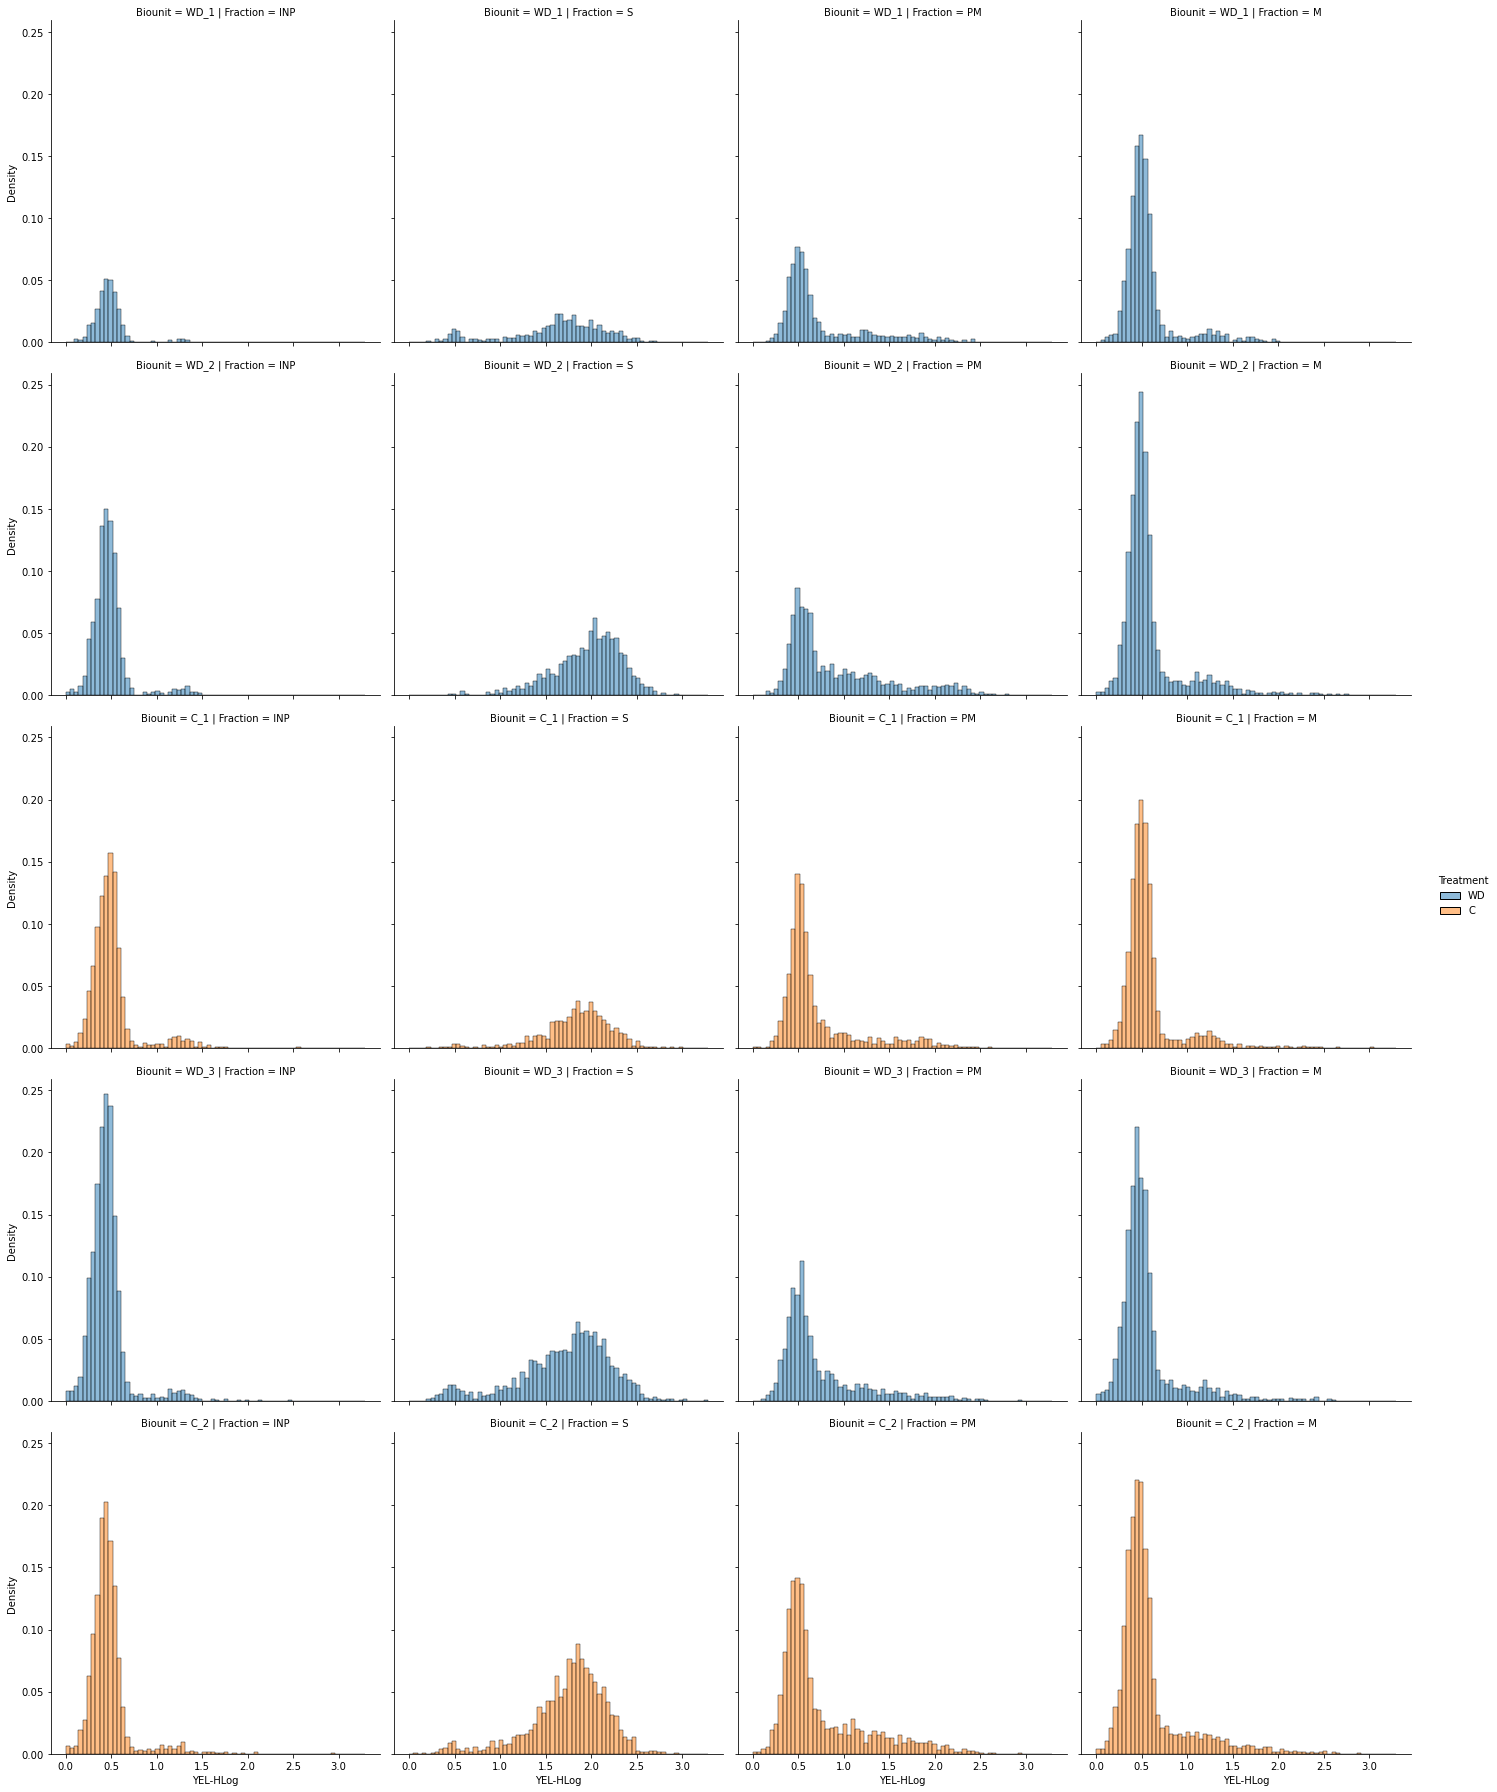

In [5]:
sns.displot(data=all_data,x="YEL-HLog",col="Fraction",row="Biounit",col_order=["INP","M","PM","S"], row_order=["WD_1","WD_2","C_1","WD_3","C_2"],stat="density",hue="Treatment")

# Enrichment calculation

The four fractions can be used to estimate:

1. Number of spermatogonia present in testicular cell suspension
2. Enrichment of spermatogonia after magnetic sorting
3. Depletion of spermatogonia after magnetic sorting

Every biounit will have it's own X value threshold. Everything below that threshold (to the left) will be considered non-spermatogonial cells, and everything above that threshold will be considered spermatogonial cells.

1. Number of spermatogonia will be calculated as percentage of cells above X threshold in "PM" fraction.
2. Enrichment will be ratio of percentage of cells above X threshold in "S" and "PM" fraction.
3. Depletion will be ratio of percentage of cells above X threshold in "PM" and "M" fraction.

Since every fraction is in 3 replicates, average of each value and its standard deviation will be reported.

Next two sections will contain biounit selector widget, X value setting slider, and textboxes displaying percentage of events above X values. They will draw scatterplot and histogram.

In [6]:
biounits=sorted(list(set(all_data.Biounit)))
biounitW = widgets.Dropdown(options=biounits,
                            value=biounits[0],
                            description="What Biounit to Draw")

v_lineW = widgets.FloatSlider(value=2,
                                min=0.0,
                                max=4.0,
                                step=0.05,
                                description = "X axis")
def scatterplot_drawer_vline(biounit,xval):
    selected_data=all_data.loc[all_data.Biounit==biounit]
    graph = sns.relplot(data=selected_data,x="YEL-HLog",y="FSC-HLog",s=1,col="Fraction",col_order=["INP","M","PM","S"])
    for ax in graph._axes_dict.values():
        ax.axvline(xval,color="red")
    for fraction in ["INP","M","PM","S"]:
        _s=selected_data.loc[selected_data.Fraction==fraction]
        _series=_s["YEL-HLog"]
        perc = np.count_nonzero(_series > xval)/len(_series)*100
        perc = round(perc,2)
        print(f"For {biounit}, in {fraction}, {perc} % of cells is above {xval}")


widgets.interactive(scatterplot_drawer_vline,biounit=biounitW,xval=v_lineW)

interactive(children=(Dropdown(description='What Biounit to Draw', options=('C_1', 'C_2', 'WD_1', 'WD_2', 'WD_…

In [12]:
def histoplot_drawer_vline(biounit,xval):
    selected_data=all_data.loc[all_data.Biounit==biounit]
    graph = sns.displot(data=selected_data,x="YEL-HLog",col="Fraction",col_order=["INP","M","PM","S"],stat="density")
    for ax in graph._axes_dict.values():
        ax.axvline(xval,color="red")
    for fraction in ["INP","M","PM","S"]:
        _s=selected_data.loc[selected_data.Fraction==fraction]
        _series=_s["YEL-HLog"]
        perc = np.count_nonzero(_series > xval)/len(_series)*100
        perc = round(perc,2)
        print(f"For {biounit}, in {fraction}, {perc} % of cells is above {xval}")


widgets.interactive(histoplot_drawer_vline,biounit=biounitW,xval=v_lineW)

interactive(children=(Dropdown(description='What Biounit to Draw', options=('C_1', 'C_2', 'WD_1', 'WD_2', 'WD_…

Next section will contain actual calculations. In order to change calculations, user needs to change default X values (provided by the creator of this Notebook)

In [13]:
#default values estimated by creator of this Notebook
#to change, simply change the following variables
biounit_threshold_dictionary={"WD_1":1.35,
                             "WD_2":1.40,
                             "WD_3":1.45,
                             "C_1":1.45,
                             "C_2":1.35}

#three functions for calculating
def poe_DIV_meanstd(series1, series2) -> tuple:
    """
    Propagation of error when dependent variable is calculated
    through division of elements of series1 over series2

    Order matters
    Parameters
    ----------
    series1 : first numpy array.
    series2 : second numpy array.

    Returns
    -------
    Tuple of ("mean","standard deviation")
    Values are floats rounded to 3, converted to strings for easier display
    """

    mean1 = np.mean(series1)
    mean2 = np.mean(series2)
    stdev1 = np.std(series1)
    stdev2 = np.std(series2)

    mean1 = np.mean(series1)
    mean2 = np.mean(series2)
    stdev1 = np.std(series1)
    stdev2 = np.std(series2)

    mean = mean1/mean2
    a = stdev1/mean1
    b = stdev2/mean2
    a = a*a
    b = b*b
    e = (a+b)**0.5
    sd = mean*e

    mean = str(round(mean, 3))
    sd = str(round(sd, 3))
    return(mean, sd)

def replicate_measurement(data, bt_dictionary, x ="YEL-HLog") -> dict:
    """
    Measures from replicates of a fraction of a given biounit


    Parameters
    ----------
    data : dataframe with biounit and fraction columns.
    x : column name.
    bt_dictionary : biounit to threshold dictionary.

    Returns
    -------
    Dictionary of the form:
        {
        BIOUNIT_1 : {Fraction_1 : percentage_above_threshold_in_fraction_1,
                     Fraction_2 : percentage_above_threshold_in_fraction_2},
        BIOUNIT_2:  {Fraction_1 : percentage_above_threshold_in_fraction_1,
                     Fraction_2 : percentage_above_threshold_in_fraction_2},

        }

    """
    biounits = list(bt_dictionary.keys())
    fractions = list(set(data.Fraction))
    biounit_fraction = {}
    for biounit in biounits:
        threshold = bt_dictionary[biounit]
        subset_bunit = data.loc[data.Biounit == biounit]
        fraction_measurement = {}
        for fraction in fractions:
            subset_fraction = subset_bunit.loc[subset_bunit.Fraction == fraction]
            replicates = list(set(subset_fraction.Replicate))
            measurements = []
            for replicate in replicates:
                subset_replicate = subset_fraction.loc[subset_fraction.Replicate == replicate]
                series = subset_replicate[x]
                above = np.count_nonzero(series > threshold)
                percentage = above/len(series)*100
                measurements.append(percentage)
                # print(f"{biounit=},{threshold=},{fraction=},{replicate=},{percentage=}")
            fraction_measurement[fraction] = measurements
        biounit_fraction[biounit] = fraction_measurement
    return(biounit_fraction)
def NED_calculation(provided_dictionary) -> pd.DataFrame:
    """
    NED = Number, Enrichment, Depletion


    Parameters
    ----------
    provided_dictionary : dictionary that functions "replicate_measurement" or "bootstrap_measurement" provide

    Returns
    -------
    Pandas DataFrame to display
    """
    biounits = list(provided_dictionary.keys())
    biounit_dictionary = {}
    for biounit in biounits:
        ned_dic = {}
        fraction_measure_dic = provided_dictionary[biounit]
        pm = np.array(fraction_measure_dic["PM"])
        ss = np.array(fraction_measure_dic["S"])
        mg = np.array(fraction_measure_dic["M"])

        number = (str(round(np.mean(pm), 3)), str(round(np.std(pm), 3)))
        enrichment = poe_DIV_meanstd(ss, pm)
        depletion = poe_DIV_meanstd(pm, mg)

        n_dis = " ± ".join(number)
        e_dis = " ± ".join(enrichment)
        d_dis = " ± ".join(depletion)

        ned_dic["Number"] = n_dis
        ned_dic["Enrichment"] = e_dis
        ned_dic["Depletion"] = d_dis
        biounit_dictionary[biounit] = ned_dic
    final_result = pd.DataFrame.from_dict(biounit_dictionary).T
    final_result.reset_index(inplace=True)

    return(final_result)
#final calculation
dictionary = replicate_measurement(all_data, bt_dictionary=biounit_threshold_dictionary)
ned = NED_calculation (dictionary)
ned.columns=["Biounit","Number","Enrichment","Depletion"]
display(ned)

,Biounit,Number,Enrichment,Depletion
0,WD_1,13.905 ± 1.62,5.589 ± 0.692,3.439 ± 0.46
1,WD_2,17.951 ± 1.175,5.113 ± 0.338,4.066 ± 0.539
2,WD_3,9.228 ± 1.685,8.058 ± 1.477,3.037 ± 0.716
3,C_1,8.981 ± 1.785,9.691 ± 1.93,3.639 ± 1.218
4,C_2,14.02 ± 0.853,6.168 ± 0.376,2.353 ± 0.159


In [9]:
#bonus section
#drawing and saving 

_l=[]
for biounit in biounits:
    for fraction in fractions:
        _s=all_data.loc[(all_data.Biounit==biounit) & (all_data.Fraction==fraction)]
        _replicate=1
        for replicate in set(_s.Replicate):
            _ss=_s.loc[_s.Replicate==replicate]
            threshold=biounit_threshold_dictionary[biounit]
            conditions=[(_ss["YEL-HLog"]>=threshold),
                        (_ss["YEL-HLog"]<threshold)]
            values=[1,0]
            _dataframe=pd.DataFrame()
            _dataframe["Marked"]=np.select(conditions,values)
            _dataframe.insert(0,"Replicate",_replicate)
            _dataframe.insert(0,"Fraction",fraction)
            _dataframe.insert(0,"Biounit",biounit)
            _replicate=_replicate+1
            _l.append(_dataframe)
global marked_dataframe
marked_dataframe=pd.concat(_l,ignore_index="True")

In [14]:
def draw_barplot_of_marked(entered_biounit): 
    dataframe=marked_dataframe.loc[marked_dataframe.Biounit==entered_biounit]
    sns.barplot(data=dataframe,x="Fraction",y="Marked").set_yticks(np.linspace(0,1,20))

widgets.interactive(draw_barplot_of_marked,entered_biounit=biounitW)

interactive(children=(Dropdown(description='What Biounit to Draw', index=1, options=('C_1', 'C_2', 'WD_1', 'WD…

In [11]:
_l=[]
for biounit in set(marked_dataframe.Biounit):
    for fraction in set(marked_dataframe.Fraction):
        for replicate in set(marked_dataframe.Replicate):
            _s=marked_dataframe.loc[(marked_dataframe.Biounit==biounit)&
                                    (marked_dataframe.Fraction==fraction)&
                                    (marked_dataframe.Replicate==replicate)
                                   ]
            average=_s["Marked"].mean()
            _l.append([biounit,fraction,replicate,average])
            
to_output=pd.DataFrame(_l,columns=["Biounit","Fraction","Replicate","Marked"])
to_output.to_csv("marked_output.csv",index=False)
            
            